In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

path = "/content/drive/MyDrive/EPFL/AppliedDataScience/Project/ada-2022-project-adlucere2022/"

In [24]:
factors = pd.read_csv(path + "./data/factor_assignment.csv")
topics = pd.read_csv(path + "./data/movie_topic_distribution.csv")[["topic_1", "topic_2", "topic_3", "topic_4", "movie_id"]]

In [25]:
# Load Data and keep year from release date
data = pd.read_csv(path + "./data/movie_data_imdbscores.csv")
data.release_date = pd.to_datetime(data.release_date).apply(lambda x: x.year)

# Select features to keep in analysis


# WE DO NOT KEEP RUN TIME AND ACTOR AGE AT MOVIE RELEASE BECAUSE OF NA


to_keep = ['movie_id', 'release_date', 
           #'runtime', 'actor_age_at_movie_release',
       'english language','german language', 'silent film language', 'spanish language',
       'japanese language', 'italian language', 'tamil language',
       'hindi language', 'malayalam language', 'mandarin language',
       'french language', 'Action', 'Adventure', 'Horror', 'Thriller', 'Drama',
       'Crime Fiction', 'Black-and-white', 'Comedy', 'Indie', 'Short Film',
       'Silent film', 'Family Film', 'World cinema', 'Musical',
       'Action/Adventure', 'Romance Film', 'Romantic drama', 'Comedy film',
       'Documentary', 'F_gender_porportion', 'averageRating',
       'numVotes']
data = data[to_keep].set_index('movie_id')

Join dataset with engineered features (topics and factors).

In [26]:
data = data.merge(factors, left_on = 'movie_id', right_on = 'movie_id').merge(topics, left_on = 'movie_id', right_on = 'movie_id')

In [27]:
data.head()

,movie_id,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,...,F_gender_porportion,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
0,30332673,2010,False,False,False,False,False,False,False,False,...,0.666667,3.7,3222,0,1,0,0.633801,0.099370,0.236645,0.030183
1,4213160,1971,True,False,False,False,False,False,False,False,...,0.250000,6.3,2631,1,0,0,0.165583,0.188212,0.245007,0.401198
2,20624798,2008,True,False,False,False,False,False,False,False,...,0.111111,7.2,22,0,0,1,0.801630,0.024238,0.107932,0.066200
3,2250713,1988,True,False,False,False,False,False,False,False,...,0.000000,5.9,82,1,0,0,0.635494,0.272188,0.073477,0.018841
4,10331139,1974,True,False,False,False,False,False,False,False,...,1.000000,5.4,1277,0,0,1,0.378305,0.029088,0.236551,0.356057


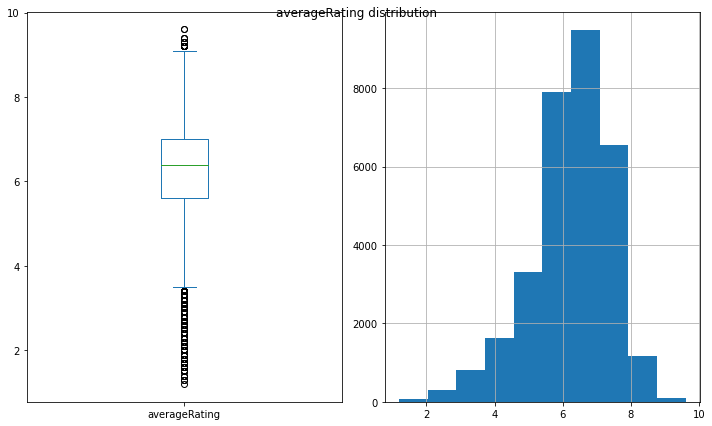

In [28]:
# Plot averageRating distribution

fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax = ax.flatten()
data.averageRating.plot.box(ax = ax[0])
data.averageRating.hist(ax = ax[1])
fig.suptitle("averageRating distribution")
plt.tight_layout()
plt.show()

In [29]:
data.averageRating.describe()

count    31291.000000
mean         6.236113
std          1.164524
min          1.200000
25%          5.600000
50%          6.400000
75%          7.000000
max          9.600000
Name: averageRating, dtype: float64

In [30]:
# Discretize feature based on quantiles
def discretize_column(data, n, label_suffix = "_star"):
    
    # Compute proportion for quantile
    p = 1/(n)
    
    # Return semgments
    return pd.cut(data,
                  # Create interval cuts
                  bins = [np.quantile(data, x * p) if x != n else np.inf
                          for x in range(n+1)],
                  right = False,
                  # assign labels
                  labels = [f"{i+1}{label_suffix}" for i in range(n)])

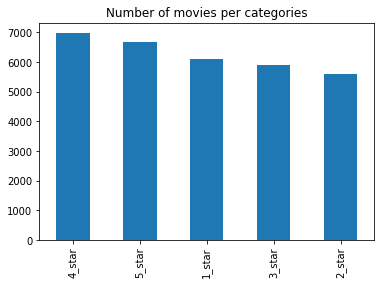

In [31]:
# Perform discretization and save categories in new feature
data["score_discretized"] = discretize_column(data.averageRating, 5)

# Verify Discretization proportions
data.score_discretized.value_counts().plot.bar()
plt.title("Number of movies per categories")
plt.show()

In [32]:
# Compute mean proportions and means for numeric values
grouped = data.groupby('score_discretized')
grouped_means = grouped.mean()
grouped_means

,movie_id,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,...,F_gender_porportion,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1.534376e+07,1992.321786,0.680512,0.011492,0.007716,0.021835,0.017895,0.021507,0.023149,0.069775,...,0.342841,4.420440,3534.902972,0.533902,0.318339,0.147759,0.448480,0.223441,0.090598,0.237481
2_star,1.406119e+07,1984.500802,0.716907,0.015322,0.010511,0.029396,0.021379,0.020666,0.017103,0.045608,...,0.343848,5.727258,6468.271869,0.518974,0.333690,0.147337,0.493833,0.206208,0.103511,0.196448
3_star,1.323335e+07,1981.038682,0.706250,0.018750,0.014189,0.034966,0.028716,0.023818,0.015372,0.040878,...,0.342836,6.304020,9307.742230,0.510811,0.336486,0.152703,0.504014,0.210168,0.100259,0.185558
4_star,1.200842e+07,1980.180269,0.652778,0.033219,0.019903,0.044387,0.031357,0.030212,0.017039,0.051833,...,0.334763,6.842511,13110.968499,0.512314,0.342354,0.145332,0.512678,0.216372,0.088010,0.182940
5_star,1.095490e+07,1982.277271,0.559479,0.043693,0.015562,0.043094,0.043992,0.035613,0.036810,0.068233,...,0.317061,7.624465,43490.467455,0.507706,0.338920,0.153374,0.516674,0.221678,0.074436,0.187213


In [33]:
# Visualize the best and worst scoring groups

grouped_means.iloc[[0,-1], :]

,movie_id,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,...,F_gender_porportion,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1.534376e+07,1992.321786,0.680512,0.011492,0.007716,0.021835,0.017895,0.021507,0.023149,0.069775,...,0.342841,4.420440,3534.902972,0.533902,0.318339,0.147759,0.448480,0.223441,0.090598,0.237481
5_star,1.095490e+07,1982.277271,0.559479,0.043693,0.015562,0.043094,0.043992,0.035613,0.036810,0.068233,...,0.317061,7.624465,43490.467455,0.507706,0.338920,0.153374,0.516674,0.221678,0.074436,0.187213


In [34]:
# test features over dataframe with significance sidak correction
def test_over_variables(n_tests, vars, alpha, t1, t2):
    
    # Sidak correction with k = n_tests
    alpha_c = 1 - (1 - alpha)**(1/n_tests)

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha_c:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha_c:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")
    
    return pvalues

In [35]:
df_list = []

print("MEAN PROPORTION OF LANGUAGES GENRES ETC TEST")

# Iterate on all comparison combinations
for (label_1,df_1), (label_2, df_2) in combinations(grouped, 2):
    
    # Drop the separating feature
    vars = df_1.columns.drop('score_discretized')
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
        
    print(f"{label_1} vs {label_2}")
    # Test over all variables with 0.05 significance
    pvalues = test_over_variables(len(vars), vars, 0.05, df_1, df_2)
    
    
    # Save results
    df_list.append(pd.DataFrame([pvalues], index = [f"{label_1}_vs_{label_2}"], columns = vars))
    

# Append al results
comparison_df = pd.concat(df_list, axis = 0)

MEAN PROPORTION OF LANGUAGES GENRES ETC TEST
>>>>>>>>>>>>>>>>>>>>>>>>>>
1_star vs 2_star
_____________________________
42 t-tests with significance: 0.00122
_____________________________
Manifestation of underlying effect between groups in vars:
movie_id -> pvalue: 8.729170189088422e-11
release_date -> pvalue: 1.2141329373808349e-79
english language -> pvalue: 1.8238188217556087e-05
hindi language -> pvalue: 2.3679985520747233e-08
malayalam language -> pvalue: 0.0011995770490764775
Action -> pvalue: 4.9520285577438306e-08
Horror -> pvalue: 1.6830578194081278e-67
Thriller -> pvalue: 9.090935404092135e-08
Drama -> pvalue: 6.730621936082908e-46
Crime Fiction -> pvalue: 2.9941589387818995e-06
Black-and-white -> pvalue: 1.0264339750486365e-18
Comedy -> pvalue: 6.65862026490666e-05
Short Film -> pvalue: 2.6475617132461767e-08
Silent film -> pvalue: 0.0004291190193027494
Romance Film -> pvalue: 4.216587681603004e-20
Romantic drama -> pvalue: 4.1015705262203585e-08
averageRating -> pvalue: 0.0

In [36]:
# Show t-test results
comparison_df

,movie_id,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,...,F_gender_porportion,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
1_star_vs_2_star,8.729170e-11,1.214133e-79,1.823819e-05,7.113388e-02,1.108236e-01,9.481108e-03,1.740422e-01,7.518913e-01,2.034782e-02,2.367999e-08,...,8.044363e-01,0.0,2.501171e-19,0.106107,0.076667,0.948675,9.330890e-29,6.493090e-07,7.836085e-12,4.563595e-34
1_star_vs_3_star,1.147676e-27,3.408165e-155,2.226596e-03,1.096789e-03,6.374816e-04,1.429687e-05,8.250054e-05,3.948580e-01,1.958432e-03,4.527405e-12,...,9.991327e-01,0.0,2.528528e-36,0.011305,0.034078,0.448376,1.804199e-42,1.177818e-04,1.633749e-07,6.296236e-56
1_star_vs_4_star,3.091694e-73,9.392562e-192,7.970604e-04,1.456641e-16,4.276614e-09,1.110893e-12,9.020044e-07,1.862964e-03,1.254491e-02,1.676825e-05,...,3.866567e-02,0.0,4.058745e-55,0.013689,0.003605,0.695452,1.065015e-60,3.371113e-02,1.353430e-01,1.070447e-67
1_star_vs_5_star,1.348559e-119,4.102563e-139,3.310789e-45,4.821320e-28,4.154360e-05,1.726777e-11,3.200531e-17,1.976635e-06,6.778259e-06,7.311950e-01,...,9.133451e-11,0.0,5.479814e-84,0.003074,0.013414,0.375637,3.503730e-67,5.945871e-01,1.597218e-21,2.209761e-53
2_star_vs_3_star,2.579749e-05,1.943975e-13,2.067925e-01,1.555651e-01,7.443382e-02,9.060544e-02,1.188395e-02,2.518498e-01,4.618359e-01,2.116674e-01,...,8.042942e-01,0.0,1.090315e-07,0.380687,0.750481,0.420017,1.379675e-02,2.513401e-01,9.835185e-02,5.780667e-04
2_star_vs_4_star,5.413291e-28,1.140561e-21,1.518540e-14,1.901053e-10,2.519748e-05,1.126041e-05,5.810852e-04,8.103871e-04,9.779406e-01,1.079439e-01,...,2.121520e-02,0.0,6.754724e-23,0.457282,0.307090,0.751683,2.121602e-06,2.398857e-03,5.212966e-17,8.073546e-06
2_star_vs_5_star,3.278768e-59,5.404638e-07,1.473544e-73,9.678193e-20,1.472261e-02,5.882641e-05,4.193988e-12,7.854733e-07,3.484694e-11,8.659643e-08,...,2.495631e-11,0.0,2.804028e-66,0.213121,0.541016,0.351192,1.153806e-08,3.300797e-06,1.383527e-57,3.527286e-03
3_star_vs_4_star,2.016465e-11,5.883544e-02,9.237439e-11,3.513394e-07,1.307478e-02,6.541437e-03,3.819708e-01,2.628370e-02,4.557606e-01,3.327177e-03,...,3.975657e-02,0.0,1.509038e-07,0.864862,0.483163,0.241005,2.830296e-02,6.228053e-02,1.206732e-11,3.750412e-01
3_star_vs_5_star,2.996789e-34,5.697254e-03,1.149146e-65,1.828682e-15,5.258206e-01,1.905446e-02,5.454360e-06,1.086886e-04,9.112735e-14,2.000339e-11,...,1.135683e-10,0.0,1.385772e-58,0.727895,0.773180,0.916780,1.470798e-03,5.055558e-04,6.501283e-48,5.919649e-01
4_star_vs_5_star,2.395260e-09,9.855995e-07,4.644897e-29,1.432470e-03,5.492239e-02,7.119042e-01,1.021587e-04,7.663125e-02,7.369679e-13,5.320270e-05,...,3.985344e-06,0.0,1.982188e-52,0.590160,0.671981,0.187249,2.942098e-01,9.673748e-02,3.349418e-16,1.461082e-01


In [37]:
# Divide dataset for logistic regression

# 1 vs all approach

def one_vs_all_encode(x, th):
    return np.where(x >= th, '5_star', 'other')

data['1vsall'] = one_vs_all_encode(data['score_discretized'] == '5_star', 0.5)

y = data['1vsall']

x_ = data.drop(['score_discretized', 'averageRating', 'numVotes', '1vsall'], axis = 1)

X = (x_ - x_.mean(axis = 0)) / x_.std(axis = 0)

In [38]:
# Fit Model and retrieve coefficients
lr = LogisticRegression()
lr.fit(X,y)
coefs = lr.coef_.flatten()
print(f'Accuracy: {lr.score(X, y)}')

Accuracy: 0.7897478508197245


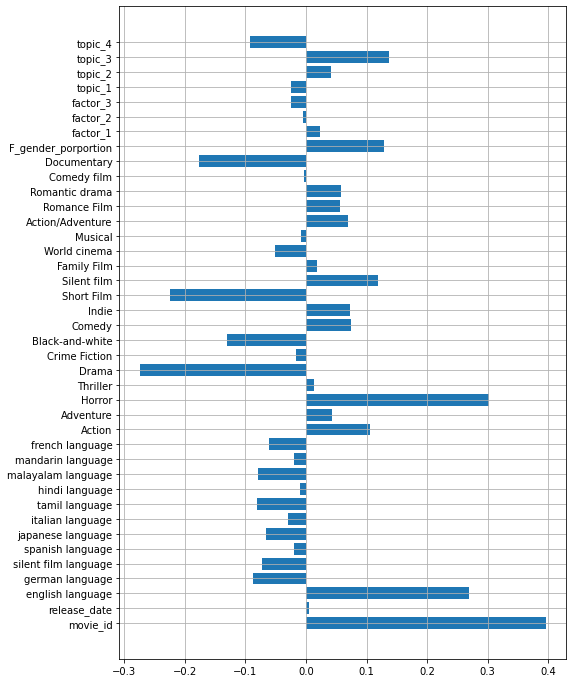

In [39]:
# Plot coefficients
plt.figure(figsize= (8,12))
plt.barh(range(len(coefs)), coefs)
plt.yticks(range(len(coefs)), labels = x_.columns)
plt.grid()
plt.show()

In [40]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": lr.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.44393751549714855, best cutoff: 0.20833333333333331, best accuracy: 0.6416541497555207


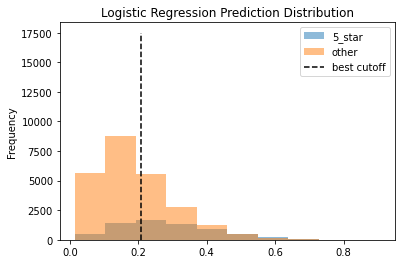

In [41]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Logistic Regression Prediction Distribution")
plt.vlines(best_cutoff, 0, 17500, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

In [42]:
rf = RandomForestClassifier(10)

rf.fit(X, y)

importances = rf.feature_importances_

print(f"Random Forest accuracy: {rf.score(X, y)}")

Random Forest accuracy: 0.9933527212297466


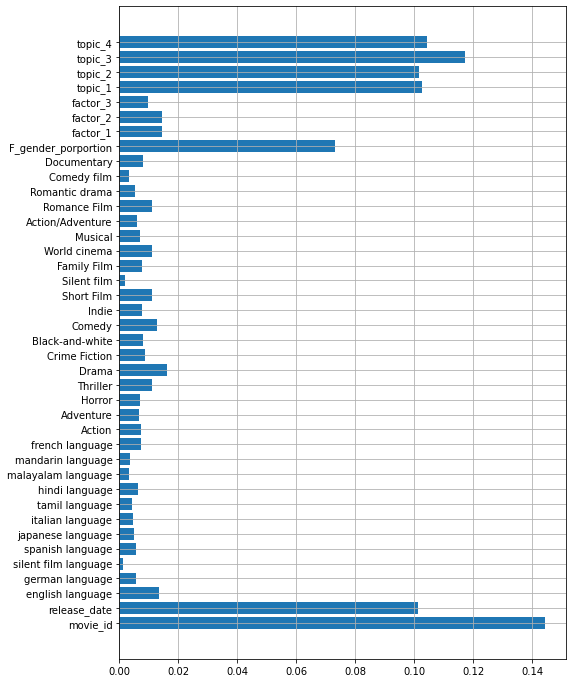

In [43]:
# Plot importances
plt.figure(figsize= (8,12))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), labels = x_.columns)
plt.grid()
plt.show()

In [44]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": rf.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.9842995169082125, best cutoff: 0.41666666666666663, best accuracy: 0.9933527212297466


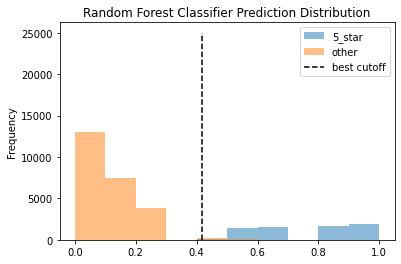

In [45]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Random Forest Classifier Prediction Distribution")
plt.vlines(best_cutoff, 0, 25000, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

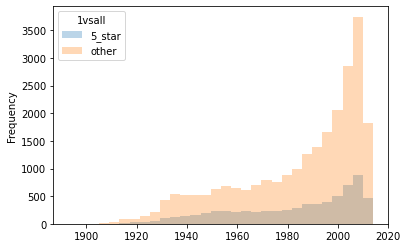

In [46]:
# Release date appears to be important in RF Lets plot its distribution

data.pivot(values = 'release_date', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

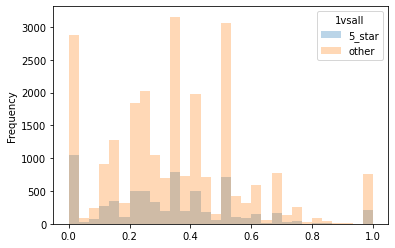

In [47]:
# apparently also gender?

data.pivot(values = 'F_gender_porportion', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

At first glance I cannot find any difference in the distributions. So the Random Forest has to be able to figure out the combinations to make it better.

In [49]:


# Iterate on all comparison combinations
for (label_1,df_1), (label_2, df_2) in combinations(data.groupby('1vsall'), 2):
    
    # Drop the separating feature
    vars = df_1.columns.drop(['1vsall','score_discretized'])
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
        
    print(f"{label_1} vs {label_2}")
    # Test over all variables with 0.05 significance
    pvalues = test_over_variables(len(vars), vars, 0.05, df_1, df_2)

>>>>>>>>>>>>>>>>>>>>>>>>>>
5_star vs other
_____________________________
42 t-tests with significance: 0.00122
_____________________________
Manifestation of underlying effect between groups in vars:
movie_id -> pvalue: 1.6925007627301504e-73
release_date -> pvalue: 5.61045723183364e-10
english language -> pvalue: 1.7540050395148175e-85
german language -> pvalue: 2.656213966637664e-27
spanish language -> pvalue: 8.790026995903067e-05
japanese language -> pvalue: 3.950590425347918e-16
italian language -> pvalue: 4.0824722466961476e-07
tamil language -> pvalue: 3.895424484145731e-20
hindi language -> pvalue: 4.0718689220939463e-07
malayalam language -> pvalue: 1.190153297626772e-10
french language -> pvalue: 1.7122202829155277e-27
Action -> pvalue: 1.9207140882829139e-28
Adventure -> pvalue: 5.063363819548401e-09
Horror -> pvalue: 5.943461371490311e-72
Thriller -> pvalue: 2.0003011813194082e-10
Drama -> pvalue: 1.031922244538389e-91
Black-and-white -> pvalue: 1.8186680347997783e-25
Comed